# Heterogeneous GNN

This notebook contains the code for the heterogeneous GNN training on pytorch graph dataset. 

In [1]:
# Torch
import torch
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import HeteroConv, SAGEConv, Linear
from torch_geometric.loader import DataLoader

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Scikit-learn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc

# Misc
import os
import time
from math import ceil


os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Path constants
PATH_GRAPH_DATA = '../../data/matches-processed/cs2/hetero-graph/'
PATH_MODELS = '../../model/gnn/'

----
## Data load

Load the data

In [2]:
hetero_data = torch.load(PATH_GRAPH_DATA + '100000.pt', weights_only=False)
hetero_data[0]

HeteroData(
  y={
    numerical_match_id=100000.0,
    tick=2.0,
    round=0.041666668,
    time=0.2931912,
    remaining_time=0.06492186,
    freeze_end=-0.0033432608,
    end=0.006661289,
    CT_alive_num=1.0,
    T_alive_num=1.0,
    CT_total_hp=1.0,
    T_total_hp=1.0,
    CT_equipment_value=0.12108262,
    T_equipment_value=0.16613925,
    CT_losing_streak=0.2,
    T_losing_streak=0.2,
    is_bomb_dropped=0.0,
    is_bomb_being_planted=0.0,
    is_bomb_being_defused=0.0,
    is_bomb_defused=0.0,
    is_bomb_planted_at_A_site=0.0,
    is_bomb_planted_at_B_site=0.0,
    bomb_X=0.0,
    bomb_Y=0.0,
    bomb_Z=0.0,
    bomb_mx_pos1=0.0,
    bomb_mx_pos2=0.0,
    bomb_mx_pos3=0.0,
    bomb_mx_pos4=0.0,
    bomb_mx_pos5=0.0,
    bomb_mx_pos6=0.0,
    bomb_mx_pos7=0.0,
    bomb_mx_pos8=0.0,
    bomb_mx_pos9=0.0,
    CT_wins=0.0,
  },
  player={ x=[10, 163] },
  map={ x=[199, 9] },
  (map, connected_to, map)={ edge_index=[2, 462] },
  (player, closest_to, map)={ edge_index=[2, 10] }
)

----
## Heterogeneous GNN

In this section, the heterogeneous GNN model is defined as well as the essentials for the training process, including data loaders, loss metrics, optimizer, the training / validation / test functions along with the plotting one to make interpretation easy.

In [22]:
class HeterogeneousGNN(torch.nn.Module):

    # --------------------------------------------------
    # Initialization
    # --------------------------------------------------

    def __init__(self, hidden_channels, conv_layers, dense_layers, edge_types):

        super().__init__()

        # Set seed for reproducibility
        torch.manual_seed(42)

        # Create convolutional layers
        self.convs = torch.nn.ModuleList()
        for _ in range(conv_layers):
            conv = HeteroConv({
                    edge_type: SAGEConv((-1, -1), hidden_channels)
                    for edge_type in edge_types
                }, aggr='mean')
            self.convs.append(conv)

        # Create linear layer 
        self.linear = Linear(-1, dense_layers[0]['input_neuron_num'])
        
        # Create dense layers based on the 'dense_layers' parameter
        dense_layers_container = []
        for layer_config in dense_layers:

            if layer_config['dropout'] == 0:
                # Add the first layer manually because it has a different input size
                dense_layers_container.append(torch.nn.Linear(layer_config['input_neuron_num'], layer_config['neuron_num']))
                
                # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                if layer_config['activation_function'] is not None:
                    dense_layers_container.append(layer_config['activation_function'])

                # Add the rest of the layers (if there are any)
                for _ in range(layer_config['num_of_layers'] - 1):
                    dense_layers_container.append(torch.nn.Linear(layer_config['neuron_num'], layer_config['neuron_num']))

                    # Add activation function if it is not None - the last layer does not have sigmoid activation function because of the BCEWithLogitsLoss
                    if layer_config['activation_function'] is not None:
                        dense_layers_container.append(layer_config['activation_function'])
            else:
                dense_layers_container.append(torch.nn.Dropout(layer_config['dropout']))
        
        self.dense = torch.nn.Sequential(*dense_layers_container)
        





    # --------------------------------------------------
    # Forward pass
    # --------------------------------------------------

    def forward(self, x_dict, edge_index_dict, y, batch_size):

        # Container for the flattened graphs after the convolutions
        flattened_graphs = []

        # Do the convolutions for each graph in the batch
        for graph in range(batch_size):

            # Get the actual graph
            actual_x_dict, actual_edge_index_dict = self.get_actual_graph(x_dict, edge_index_dict, graph, batch_size)

            # Do the convolutions
            for conv in self.convs:
                temp = conv(actual_x_dict, actual_edge_index_dict)
                actual_x_dict['map'] = torch.cat([actual_x_dict['map'][:,:5], temp['map']], dim=1)
                actual_x_dict = {key: x.relu() for key, x in actual_x_dict.items()}

            # Get the graph data
            graph_data = torch.tensor([
                y['round'][graph],
                y['time'][graph],
                y['remaining_time'][graph],
                y['CT_alive_num'][graph],
                y['T_alive_num'][graph],
                y['CT_total_hp'][graph],
                y['T_total_hp'][graph],
                y['CT_equipment_value'][graph],
                y['T_equipment_value'][graph],
                y['CT_losing_streak'][graph],
                y['T_losing_streak'][graph],
                y['is_bomb_dropped'][graph],
                y['is_bomb_being_planted'][graph],
                y['is_bomb_being_defused'][graph],
                y['is_bomb_planted_at_A_site'][graph],
                y['is_bomb_planted_at_B_site'][graph],
                y['bomb_X'][graph],
                y['bomb_Y'][graph],
                y['bomb_Z'][graph],
                y['bomb_mx_pos1'][graph],
                y['bomb_mx_pos2'][graph],
                y['bomb_mx_pos3'][graph],
                y['bomb_mx_pos4'][graph],
                y['bomb_mx_pos5'][graph],
                y['bomb_mx_pos6'][graph],
                y['bomb_mx_pos7'][graph],
                y['bomb_mx_pos8'][graph],
                y['bomb_mx_pos9'][graph],
            ]).to('cuda')

            # Create the flattened input tensor and append it to the container
            x = torch.cat([torch.flatten(x_dict['player']), torch.flatten(x_dict['map']), torch.flatten(graph_data)])
            flattened_graphs.append(x)

        # Stack the flattened graphs
        x = torch.stack(flattened_graphs).to('cuda')

        x = self.linear(x)
        x = self.dense(x)
        
        return x
    






    # --------------------------------------------------
    # Helper functions
    # --------------------------------------------------

    def get_actual_graph(self, x_dict, edge_index_dict, graph_idx, batch_size):

        # Node feature dictionary for the actual graph
        actual_x_dict = {}

        single_player_node_size = int(x_dict['player'].shape[0] / batch_size)
        single_map_node_size = int(x_dict['map'].shape[0] / batch_size)

        actual_x_dict['player'] = x_dict['player'][graph_idx*single_player_node_size:(graph_idx+1)*single_player_node_size, :]
        actual_x_dict['map'] = x_dict['map'][graph_idx*single_map_node_size:(graph_idx+1)*single_map_node_size, :]


        # Edge index dictionary for the actual graph
        actual_edge_index_dict = {}

        single_map_to_map_edge_size = int(edge_index_dict[('map', 'connected_to', 'map')].shape[1] / batch_size)
        single_player_to_map_edge_size = int(edge_index_dict[('player', 'closest_to', 'map')].shape[1] / batch_size)

        actual_edge_index_dict[('map', 'connected_to', 'map')] = edge_index_dict[('map', 'connected_to', 'map')] \
            [:, graph_idx*single_map_to_map_edge_size:(graph_idx+1)*single_map_to_map_edge_size] \
            - graph_idx*single_map_node_size
        
        actual_edge_index_dict[('player', 'closest_to', 'map')] = edge_index_dict[('player', 'closest_to', 'map')] \
            [:, graph_idx*single_player_to_map_edge_size:(graph_idx+1)*single_player_to_map_edge_size]
        
        actual_edge_index_dict_correction_tensor = torch.tensor([single_player_node_size*graph_idx, single_map_node_size*graph_idx]).to('cuda')
        actual_edge_index_dict[('player', 'closest_to', 'map')] = actual_edge_index_dict[('player', 'closest_to', 'map')] - actual_edge_index_dict_correction_tensor.view(-1, 1)

        
        return actual_x_dict, actual_edge_index_dict
    


In [24]:
batch_size = 64

train_loader = DataLoader(hetero_data[:6400], batch_size=batch_size, shuffle=False)
val_loader = DataLoader(hetero_data[6400:9600], batch_size=batch_size, shuffle=False)

dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1024,
        "input_neuron_num": 1024,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 128,
        "input_neuron_num": 1024,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.5,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 16,
        "input_neuron_num": 128,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 4,
        "input_neuron_num": 16,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1,
        "input_neuron_num": 4,
        "activation_function": None
    },
]

model = HeterogeneousGNN(hidden_channels=5, conv_layers=5, dense_layers=dense_layers, edge_types=hetero_data[0].edge_types).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.02)
loss_function = torch.nn.BCEWithLogitsLoss()

with torch.no_grad():
    for batch in train_loader:

        batch = batch.to('cuda')

        out = model(batch.x_dict, batch.edge_index_dict, batch.y, batch_size)
        out = torch.sigmoid(out)
        print(out)
        break


     
print('params:', sum(p.numel() for p in model.parameters()))
print('trainable:', sum(p.numel() for p in model.parameters() if p.requires_grad))

tensor([[1.4376e-04],
        [1.9837e-04],
        [6.3093e-01],
        [3.8671e-02],
        [6.2874e-01],
        [5.9669e-01],
        [6.1237e-01],
        [5.0732e-01],
        [6.4244e-01],
        [6.3034e-01],
        [6.4423e-01],
        [9.7662e-02],
        [8.6637e-01],
        [1.4199e-01],
        [6.3288e-01],
        [2.6519e-01],
        [9.9510e-01],
        [1.1940e-06],
        [6.1656e-01],
        [9.0820e-01],
        [2.5542e-01],
        [6.2521e-01],
        [5.5920e-01],
        [6.4920e-01],
        [6.7724e-01],
        [1.8285e-01],
        [6.1467e-01],
        [6.1407e-01],
        [6.3081e-01],
        [3.0973e-03],
        [4.5034e-01],
        [5.1547e-01],
        [6.1328e-01],
        [6.1750e-01],
        [5.8358e-01],
        [6.4391e-01],
        [6.0935e-01],
        [9.9619e-01],
        [6.0963e-01],
        [2.0732e-01],
        [1.9258e-05],
        [9.2495e-01],
        [6.3094e-01],
        [2.1224e-01],
        [6.4230e-01],
        [9

In [35]:
def epoch_result_visualization(
    epochs,
    epoch,
    epoch_start,
    epoch_start_time,
    epoch_end,
    epoch_end_time,
    train_avg_loss,
    val_metrics,
    train_losses,
    val_losses, 
    accuracies, 
    precisions, 
    recalls, 
    f1_scores
):
    val_avg_loss = val_metrics[0]
    accuracy = val_metrics[1]
    precision = val_metrics[2]
    recall = val_metrics[3]
    f1 = val_metrics[4]
    cm = val_metrics[5]
    cm_normalized = val_metrics[6]
    fpr, tpr = val_metrics[7], val_metrics[8]

    print("-------------------------------------------------------------------------------------------\n"
         f"                                     Epoch {epoch}\n"
          "-------------------------------------------------------------------------------------------\n"
          "Time: \n"
         f"   -Start time: {epoch_start_time} \n"
         f"   -End time: {epoch_end_time}s \n"
         f"   -Duration: {epoch_end - epoch_start}s \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Training results:\n"
         f"   - Average loss: {train_avg_loss:.4f} \n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n"
          "Validation results: \n"
         f"   - Average loss: {val_avg_loss} \n"
         f"   - Accuracy: {accuracy} \n"
         f"   - Precision: {precision} \n"
         f"   - Recall: {recall} \n"
         f"   - F1: {f1} \n"
          "   - Confusion matrix & ROC/AUC\n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")
    
    # ----------------------------------------
    # Confusion matrix & ROC/AUC visualization
    # ----------------------------------------

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle(f'Epoch {epoch} - Validation scores', fontsize=12)


    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    # Add numbers to the confusion matrix
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # Normalized Confusion Matrix
    im = axs[1].matshow(cm_normalized, cmap='Blues', alpha=0.6)
    axs[1].set_aspect('equal')
    axs[1].set_title('Normalized confusion matrix', fontsize=10, y=1)
    axs[1].set_xlabel('Predicted', fontsize=8)
    # Add numbers to the normalized confusion matrix
    for (i, j), val in np.ndenumerate(cm_normalized):
        axs[1].text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=10, color='black')
    # Set x-ticks to bottom
    axs[1].set_xticks([0, 1])
    axs[1].set_xticklabels([0, 1])
    axs[1].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)


    # ROC/AUC Curve
    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc(fpr, tpr))
    axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_xlabel('False Positive Rate', fontsize=8)
    axs[2].set_ylabel('True Positive Rate', fontsize=8)
    axs[2].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[2].legend(loc="lower right", fontsize=8)
    axs[2].set_aspect('equal')


    plt.tight_layout()
    plt.show()



    # ----------------------------------------
    # Metrics visualization
    # ----------------------------------------

    fig, axs = plt.subplots(2, 3, figsize=(8, 4.5))
    fig.suptitle('Training and Validation Metrics Over Epochs', fontsize=12)

    epochs_range = np.arange(0, epoch + 1)

    def plot_metric(ax, data, title, ylabel, color):
        if len(data) == 1:
            ax.scatter(epochs_range, data, s=10, c=color)
        else:
            ax.plot(epochs_range, data, marker='o', linestyle='-', color=color)
        ax.set_title(title, fontsize=10)
        ax.set_xlabel('Epoch', fontsize=8)
        ax.set_ylabel(ylabel, fontsize=8)
        ax.set_xticks(epochs_range)
        ax.set_xlim(-1, epochs)
        if 'Loss' not in title:
            ax.set_ylim(0, 1)
        ax.grid(True)

    plot_metric(axs[0, 0], train_losses, 'Train Loss', 'Loss', 'cornflowerblue')
    plot_metric(axs[0, 1], val_losses, 'Validation Loss', 'Loss', 'darkorange')
    plot_metric(axs[0, 2], accuracies, 'Accuracy', 'Accuracy', 'limegreen')
    plot_metric(axs[1, 0], precisions, 'Precision', 'Precision', 'red')
    plot_metric(axs[1, 1], recalls, 'Recall', 'Recall', 'teal')
    plot_metric(axs[1, 2], f1_scores, 'F1 Score', 'F1 Score', 'black')

    plt.tight_layout()
    plt.show()



def train(model, train_loader, val_loader, batch_size, epochs):

    torch.cuda.empty_cache()

    train_losses = []
    val_losses = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for epoch in range(epochs):

        epoch_start = time.time()
        epoch_start_time = time.asctime(time.localtime()) 
        model.train()
        total_loss = 0
        
        for data in train_loader:  # Iterate in batches over the training dataset.
            data = data.to('cuda')
            optimizer.zero_grad()  # Clear gradients.
            
            out = model(data.x_dict, data.edge_index_dict, data.y, batch_size).float()  # Perform a single forward pass.
            target = torch.tensor(data.y['CT_wins']).float().to('cuda')  # Assuming target is stored in data.y

            loss = loss_function(out.squeeze(), target)  # Compute the loss.
            loss.backward()  # Backpropagate.
            optimizer.step()  # Update model parameters.

            total_loss += loss.item()  # Accumulate the loss.


        train_avg_loss = total_loss / len(train_loader)
        val_metrics = validate(val_loader, batch_size)  # Validate the model on validation dataset.
        epoch_end = time.time()
        epoch_end_time = time.asctime(time.localtime()) 

        val_avg_loss = val_metrics[0]
        accuracy = val_metrics[1]
        precision = val_metrics[2]
        recall = val_metrics[3]
        f1 = val_metrics[4]

        train_losses.append(train_avg_loss)
        val_losses.append(val_avg_loss)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

        epoch_result_visualization(epochs, epoch, epoch_start, epoch_start_time, epoch_end, epoch_end_time, train_avg_loss, val_metrics, train_losses, val_losses, accuracies, precisions, recalls, f1_scores)

        

def validate(val_loader, batch_size):
    model.eval()  # Switch to evaluation mode.
    total_loss = 0
    total_samples = 0
    predictions_all = []
    targets_all = []

    with torch.no_grad():
        for data in val_loader:  # Iterate in batches over the validation dataset.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y, batch_size).float()
            target = torch.tensor(data.y['CT_wins']).float().to('cuda')

            loss = loss_function(out.squeeze(), target)
            total_loss += loss.item()
            total_samples += len(target)

            # Get the predictions
            predictions = torch.sigmoid(out).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Calculate performance metrics
    rounded_predictions = np.round(predictions_all)
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(targets_all, rounded_predictions)
    precision = precision_score(targets_all, rounded_predictions)
    recall = recall_score(targets_all, rounded_predictions)
    f1 = f1_score(targets_all, rounded_predictions)
    cm = confusion_matrix(targets_all, rounded_predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, _ = roc_curve(targets_all, rounded_predictions)

    return avg_loss, accuracy, precision, recall, f1, cm, cm_normalized, fpr, tpr



def test(test_loader):
    model.eval()  # Switch to evaluation mode.
    total_loss = 0
    total_samples = 0
    predictions_all = []
    targets_all = []

    with torch.no_grad():
        for data in test_loader:  # Iterate in batches over the test dataset.
            data = data.to('cuda')

            out = model(data.x_dict, data.edge_index_dict, data.y).float()
            target = torch.tensor(data.y['CT_winsRound']).float().to('cuda')

            loss = loss_function(out, target)
            total_loss += loss.item()
            total_samples += len(target)

            # Get the predictions
            predictions = (torch.sigmoid(out) > 0.5).float()

            predictions_all.extend(predictions.cpu().numpy())
            targets_all.extend(target.cpu().numpy())

    # Calculate performance metrics
    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(targets_all, predictions_all)
    precision = precision_score(targets_all, predictions_all)
    recall = recall_score(targets_all, predictions_all)
    f1 = f1_score(targets_all, predictions_all)
    cm = confusion_matrix(targets_all, predictions_all)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fpr, tpr, _ = roc_curve(targets_all, predictions_all)

    print("-------------------------------------------------------------------------------------------\n"
          "                                      Test Results\n"                                     
          "-------------------------------------------------------------------------------------------\n"
         f"Average loss: {avg_loss} \n"
         f"Accuracy: {accuracy} \n"
         f"Precision: {precision} \n"
         f"Recall: {recall} \n"
         f"F1: {f1} \n"
          "Confusion matrix & ROC/AUC\n"
          ". . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n")

    fig, axs = plt.subplots(1, 3, figsize=(8, 3))
    fig.suptitle('Test results', fontsize=12)

    # Confusion Matrix
    im = axs[0].matshow(cm, cmap='Blues', alpha=0.6)
    axs[0].set_aspect('equal')
    axs[0].set_title('Confusion matrix', fontsize=10, y=1)
    axs[0].set_xlabel('Predicted', fontsize=8)
    axs[0].set_ylabel('Actual', fontsize=8)
    for (i, j), val in np.ndenumerate(cm):
        axs[0].text(j, i, f'{val}', ha='center', va='center', fontsize=10, color='black')
    axs[0].set_xticks([0, 1])
    axs[0].set_xticklabels([0, 1])
    axs[0].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

    # Normalized Confusion Matrix
    im = axs[1].matshow(cm_normalized, cmap='Blues', alpha=0.6)
    axs[1].set_aspect('equal')
    axs[1].set_title('Normalized confusion matrix', fontsize=10, y=1)
    axs[1].set_xlabel('Predicted', fontsize=8)
    for (i, j), val in np.ndenumerate(cm_normalized):
        axs[1].text(j, i, f'{val:.2f}', ha='center', va='center', fontsize=10, color='black')
    axs[1].set_xticks([0, 1])
    axs[1].set_xticklabels([0, 1])
    axs[1].tick_params(axis='x', bottom=True, top=False, labelbottom=True, labeltop=False)

    # ROC/AUC Curve
    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f' % auc(fpr, tpr))
    axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[2].set_xlim([0.0, 1.0])
    axs[2].set_ylim([0.0, 1.05])
    axs[2].set_xlabel('False Positive Rate', fontsize=8)
    axs[2].set_ylabel('True Positive Rate', fontsize=8)
    axs[2].set_title('ROC/AUC Curve', fontsize=10, y=1)
    axs[2].legend(loc="lower right", fontsize=8)
    axs[2].set_aspect('equal')

    plt.tight_layout()
    plt.show()

    return avg_loss, accuracy, precision, recall, f1, cm, cm_normalized, fpr, tpr



C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch_geometric\nn\conv\hetero_conv.py:76: UserWarning: There exist node types ({'player'}) whose representations do not get updated during message passing as they do not occur as destination type in any edge type. This may lead to unexpected behavior.
  warnings.warn(
C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------------------------------------------------------------------------
                                     Epoch 0
-------------------------------------------------------------------------------------------
Time: 
   -Start time: Fri Sep 20 23:56:36 2024 
   -End time: Fri Sep 20 23:57:34 2024s 
   -Duration: 57.80242943763733s 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Training results:
   - Average loss: 31.7514 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Validation results: 
   - Average loss: 10.890295181274414 
   - Accuracy: 0.225 
   - Precision: 0.0 
   - Recall: 0.0 
   - F1: 0.0 
   - Confusion matrix & ROC/AUC
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



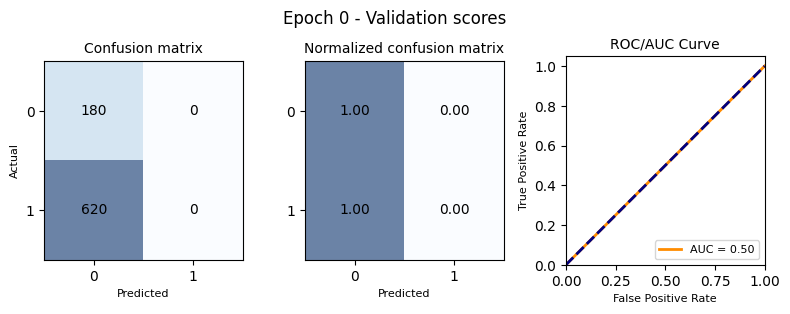

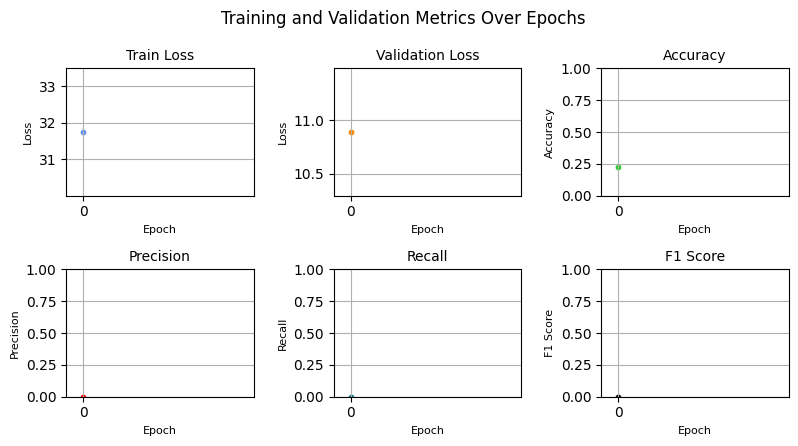

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------------------------------------------------------------------------
                                     Epoch 1
-------------------------------------------------------------------------------------------
Time: 
   -Start time: Fri Sep 20 23:57:35 2024 
   -End time: Fri Sep 20 23:58:33 2024s 
   -Duration: 58.22010517120361s 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Training results:
   - Average loss: 6.9999 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Validation results: 
   - Average loss: 4.597649550437927 
   - Accuracy: 0.225 
   - Precision: 0.0 
   - Recall: 0.0 
   - F1: 0.0 
   - Confusion matrix & ROC/AUC
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



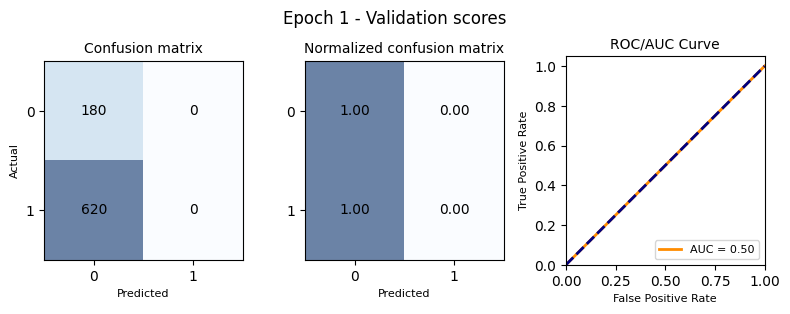

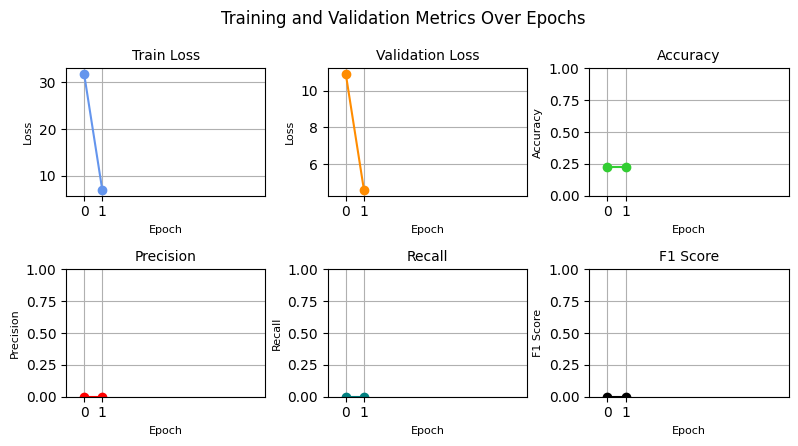

-------------------------------------------------------------------------------------------
                                     Epoch 2
-------------------------------------------------------------------------------------------
Time: 
   -Start time: Fri Sep 20 23:58:35 2024 
   -End time: Fri Sep 20 23:59:34 2024s 
   -Duration: 58.93570137023926s 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Training results:
   - Average loss: 3.1947 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Validation results: 
   - Average loss: 0.5333801037073136 
   - Accuracy: 0.775 
   - Precision: 0.775 
   - Recall: 1.0 
   - F1: 0.8732394366197183 
   - Confusion matrix & ROC/AUC
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



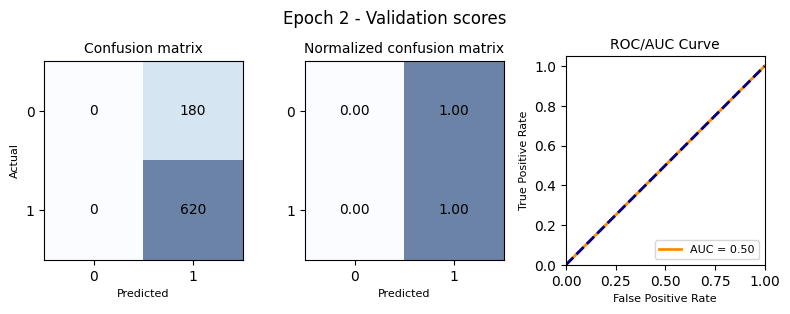

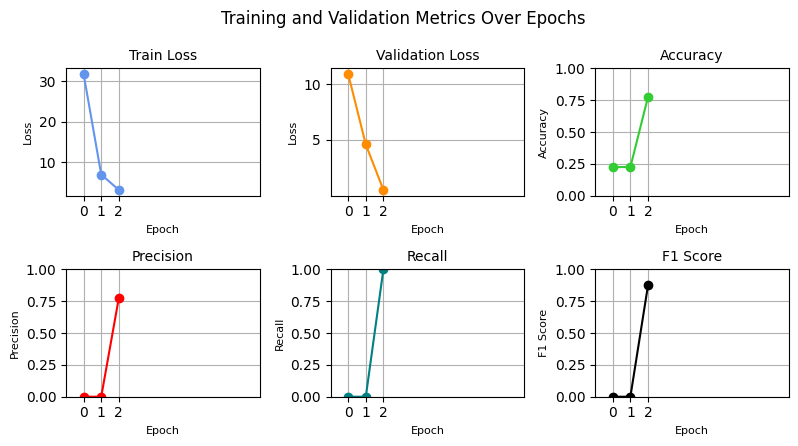

C:\Users\szmid\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


-------------------------------------------------------------------------------------------
                                     Epoch 3
-------------------------------------------------------------------------------------------
Time: 
   -Start time: Fri Sep 20 23:59:35 2024 
   -End time: Sat Sep 21 00:00:20 2024s 
   -Duration: 44.51296305656433s 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Training results:
   - Average loss: 1.3751 
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Validation results: 
   - Average loss: 2.454037754535675 
   - Accuracy: 0.225 
   - Precision: 0.0 
   - Recall: 0.0 
   - F1: 0.0 
   - Confusion matrix & ROC/AUC
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .



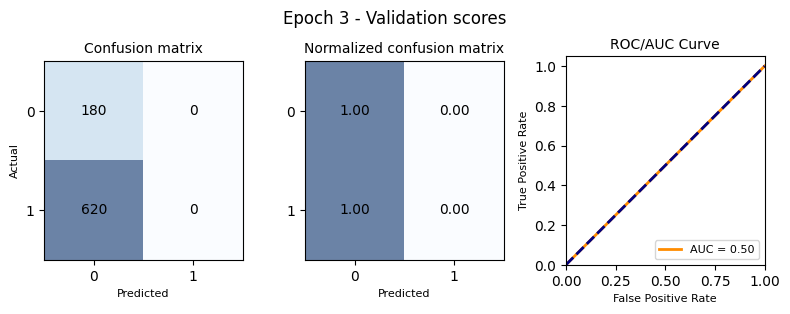

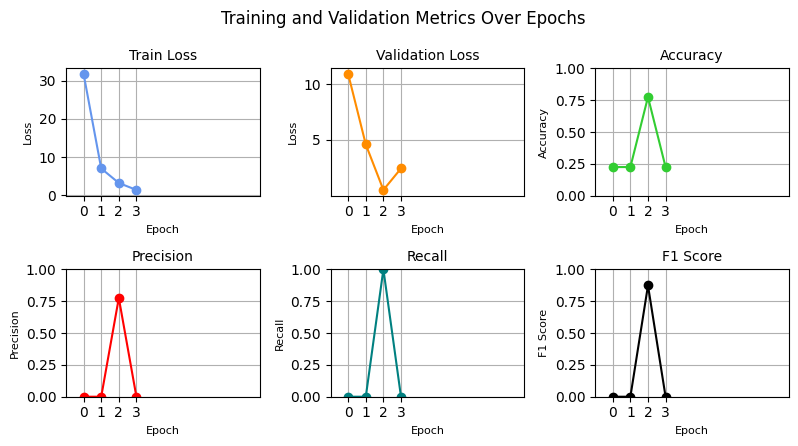

KeyboardInterrupt: 

In [39]:
batch_size = 16

train_loader = DataLoader(hetero_data[:1600], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(hetero_data[1600:2400], batch_size=batch_size, shuffle=True)

dense_layers = [
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1024,
        "input_neuron_num": 1024,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0.4,
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 16,
        "input_neuron_num": 1024,
        "activation_function": torch.nn.LeakyReLU()
    },
    {
        "dropout": 0,
        "num_of_layers": 1,
        "neuron_num": 1,
        "input_neuron_num": 16,
        "activation_function": None
    },
]

model = HeterogeneousGNN(hidden_channels=5, conv_layers=5, dense_layers=dense_layers, edge_types=hetero_data[0].edge_types).to('cuda')
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.02)
loss_function = torch.nn.BCEWithLogitsLoss()

train(model, train_loader, val_loader, batch_size, 10)